# Install Library

In [ ]:
!pip install torch ultralytics scikit-learn mplsoccer --quiet

# Import Library

In [ ]:
import os
import cv2
import yaml
import time
import json
import torch
import shutil
import psutil
import random
import platform
import subprocess
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from mplsoccer import Pitch
from ultralytics import YOLO
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pandas import DataFrame, merge
import matplotlib.patches as mpatches
from datetime import datetime, timedelta, timezone

# torch.cuda.empty_cache()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Check Specification

In [ ]:
# CPU info
print("🔹 CPU info:")
print("CPU count:", os.cpu_count())
print("Processor:", platform.processor())
!lscpu | grep 'Model name'

# RAM info
print("\n🔹 RAM info:")
ram_bytes = psutil.virtual_memory().total
print("Total RAM (GB):", round(ram_bytes / (1024**3), 2))

# Disk info
print("\n🔹 Disk info:")
disk = psutil.disk_usage('/')
print("Total Disk (GB):", round(disk.total / (1024**3), 2))
print("Used Disk (GB):", round(disk.used / (1024**3), 2))
print("Free Disk (GB):", round(disk.free / (1024**3), 2))

# GPU info
print("\n🔹 GPU info:")
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
!nvidia-smi


🔹 CPU info:
CPU count: 12
Processor: x86_64
Model name:                              Intel(R) Xeon(R) CPU @ 2.20GHz

🔹 RAM info:
Total RAM (GB): 83.47

🔹 Disk info:
Total Disk (GB): 112.64
Used Disk (GB): 39.16
Free Disk (GB): 73.46

🔹 GPU info:
CUDA available: True
CUDA device count: 1
Wed Nov 12 08:07:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB        

# Main Code

## Train Model

In [ ]:
# Load pretrained YOLOv8-pose model (you can pick yolov8n-pose.pt for smallest)
model_type = "nano" # nano, small, medium, large, xlarge
model = YOLO('yolov8n-pose.pt')  # yolov8n-pose.pt, yolov8s-pose.pt, yolov8m-pose.pt, yolov8x-pose.pt, yolov8x-pose.pt
print("✅ Model is successfully loaded.")

# Start training
WIB = timezone(timedelta(hours=7)) # (WIB = UTC+7)
start_time = time.time()
start_timestamp = datetime.now(WIB).strftime('%Y-%m-%d %H:%M:%S')
print(f"✅ Start Model Training at {start_timestamp} (WIB)")

# Train on your dataset using only CPU
model.train(
    data='/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml',
    epochs=500,
    imgsz=640,
    batch=32,
    # device='cpu',
    # workers=2,
    device=0,           # 0 = GPU
    workers=12,
    optimizer='SGD',
    lr0=0.01,
    # patience=10,        # early stopping if not improved
    mosaic=0.0          # nonactivated mosaic
)

# Finish training
end_time = time.time()
end_timestamp = datetime.now(WIB).strftime('%Y-%m-%d %H:%M:%S')
print(f"✅ End Model Training at {end_timestamp} (WIB)")
elapsed_time = end_time - start_time

# Formatting time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
elapsed_str = f"{int(hours)}h {int(minutes)}m {int(seconds)}s"

# Folder source and destination
timestamp = datetime.now(WIB).strftime('%Y%m%d-%H%M%S')
output_dir = '/content/runs/pose'
backup_dir = f'/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-{model_type}-{timestamp}'

# Copy folder training result
shutil.copytree(output_dir, backup_dir)
print(f"✅ Training results have been copied to: {backup_dir}")
print(f"⏱️ Total training time: {elapsed_str}")


## Test Model (optional)

In [ ]:
# Load model from the training result
model_type = "nano" #nano, small, medium, large, xlarge
model = YOLO('/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/weights/best.pt')


# Start testing
WIB = timezone(timedelta(hours=7)) # (WIB = UTC+7)
start_time = time.time()
start_timestamp = datetime.now(WIB).strftime('%Y-%m-%d %H:%M:%S')
print(f"✅ Start Model Testing at {start_timestamp} (WIB)")

result = model.val(
    data='/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml',
    imgsz=640,
    batch=32,
    device=0, #GPU
    workers=2,
    # device=0,
    # workers=12,
    split='test'
)

# Finish testing
end_time = time.time()
end_timestamp = datetime.now(WIB).strftime('%Y-%m-%d %H:%M:%S')
print(f"✅ End Model Testing at {end_timestamp} (WIB)")
elapsed_time = end_time - start_time

# Format time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
elapsed_str = f"{int(hours)}h {int(minutes)}m {int(seconds)}s"

# print(metrics)

# Folder source and destination
timestamp = datetime.now(WIB).strftime('%Y%m%d-%H%M%S')
output_dir = '/content/runs/pose'
backup_dir = f'/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup_val-{model_type}-{timestamp}'

# Copy folder training result
shutil.copytree(output_dir, backup_dir)
print(f"✅ Training result is copied to: {backup_dir}")
print(f"⏱️ Total training time: {elapsed_str}")


✅ Start Model Testing at 2025-11-12 15:09:01 (WIB)
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8n-pose summary (fused): 81 layers, 3,670,259 parameters, 0 gradients, 10.9 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 20.4±18.8 MB/s, size: 60.1 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 52/52 72.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.2it/s 11.4s
                   all         52         52      0.999          1      0.995      0.994       0.98      0.981      0.985      0.603
Speed: 1.4ms preprocess, 70.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/pose/val3
✅ End Model Testing at 2025-11-12 15:09:16 (WIB)
✅ Training result is co

## Training, validation and mAP

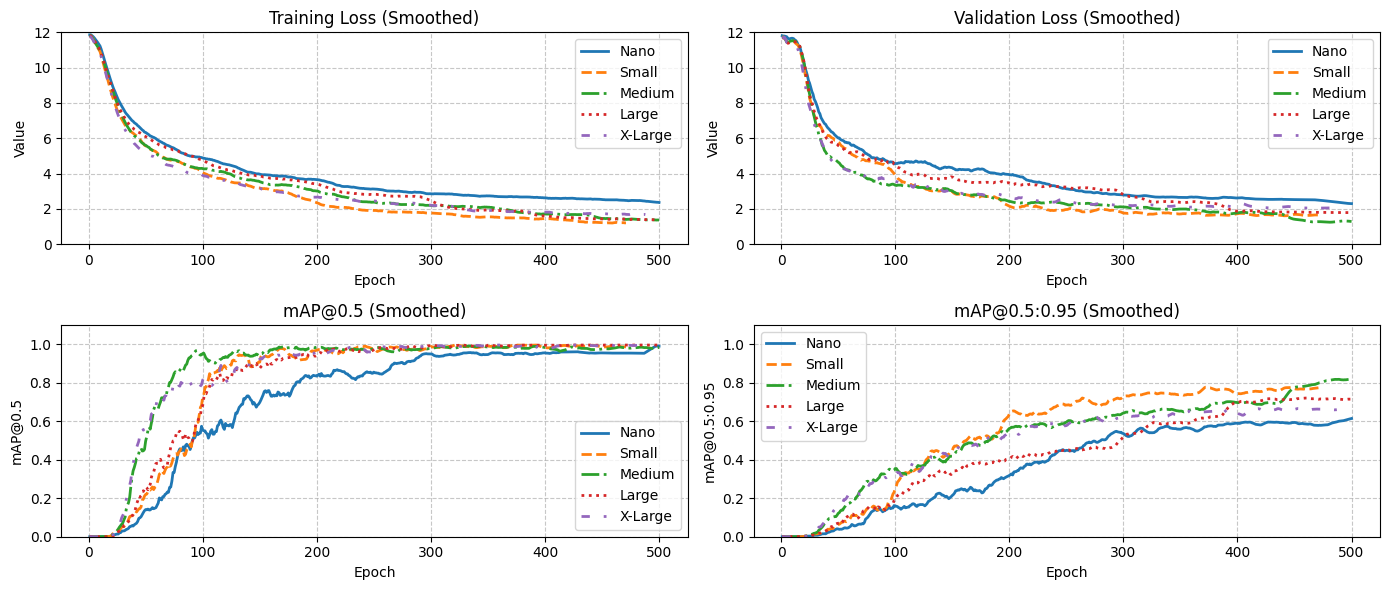

In [ ]:
# Folder training result
model_files = {
    'Nano': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/',
    'Small': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-small-20250808-134916/train16/',
    'Medium': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/',
    'Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-large-20250808-111612/train13/',
    'X-Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-xlarge-20250808-102744/train12/'
}


# Definition of different line styles
linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]

# Create a figure with 2x2 subplots and flatten axes to 1D
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
axes = axes.flatten()

for idx, (model_name, folder_path) in enumerate(model_files.items()):
    csv_path = os.path.join(folder_path, "results.csv")
    if not os.path.exists(csv_path):
        print(f"⚠️ CSV untuk {model_name} tidak ditemukan: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    # Smoothing with moving average window=10
    df['smooth_train_pose_loss'] = df["train/pose_loss"].rolling(window=10, min_periods=1).mean()
    df['smooth_val_pose_loss'] = df['val/pose_loss'].rolling(window=10, min_periods=1).mean()
    df['smooth_mAP50(P)'] = df['metrics/mAP50(P)'].rolling(window=10, min_periods=1).mean()
    df['smooth_mAP50-95(P)'] = df['metrics/mAP50-95(P)'].rolling(window=10, min_periods=1).mean()

    # Select linestyle based on model order
    ls = linestyles[idx % len(linestyles)]

    # Plot
    axes[0].plot(df['epoch'], df['smooth_train_pose_loss'], label=model_name, linewidth=2, linestyle=ls)
    axes[1].plot(df['epoch'], df['smooth_val_pose_loss'], label=model_name, linewidth=2, linestyle=ls)
    axes[2].plot(df['epoch'], df['smooth_mAP50(P)'], label=model_name, linewidth=2, linestyle=ls)
    axes[3].plot(df['epoch'], df['smooth_mAP50-95(P)'], label=model_name, linewidth=2, linestyle=ls)

# Configuration plot
titles = [
    "Training Loss (Smoothed)",
    "Validation Loss (Smoothed)",
    "mAP@0.5 (Smoothed)",
    "mAP@0.5:0.95 (Smoothed)"
]
ylabels = ["Value", "Value", "mAP@0.5", "mAP@0.5:0.95"]

for i in range(4):
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel(ylabels[i])
    axes[i].grid(True, linestyle="--", alpha=0.7)
    if i > 1:
        axes[i].set_ylim(0, 1.1)
    else:
        axes[i].set_ylim(0, 12)
    axes[i].legend()

plt.tight_layout()
plt.show()


## Model sizes

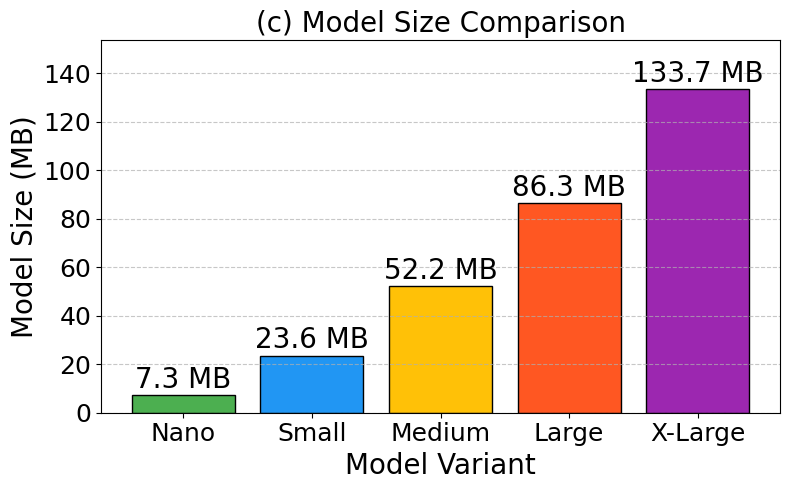

In [ ]:
# Path to model file (.pt)
model_files = {
    'Nano': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/weights/best.pt',
    'Small': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-small-20250808-134916/train16/weights/best.pt',
    'Medium': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/weights/best.pt',
    'Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-large-20250808-111612/train13/weights/best.pt',
    'X-Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-xlarge-20250808-102744/train12/weights/best.pt'
}

# Get file size in MB
model_names = []
model_sizes = []

for name, file_path in model_files.items():
    if os.path.exists(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
        model_names.append(name)
        model_sizes.append(size_mb)
    else:
        print(f"⚠ File tidak ditemukan: {file_path}")

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, model_sizes,
               color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0'],
               edgecolor='black')

# Add size label above the bar
for bar, size in zip(bars, model_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{size:.1f} MB", ha='center', va='bottom', fontsize=20)

plt.ylabel("Model Size (MB)", fontsize=20)
plt.xlabel("Model Variant", fontsize=20)
plt.title("(c) Model Size Comparison", fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(model_sizes)+20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## Latency

🔍 Evaluating Nano...
Nano - 🕒 FPS: 62.12, Latency: 16.10 ms
🔍 Evaluating Small...
Small - 🕒 FPS: 59.78, Latency: 16.73 ms
🔍 Evaluating Medium...
Medium - 🕒 FPS: 50.83, Latency: 19.67 ms
🔍 Evaluating Large...
Large - 🕒 FPS: 43.90, Latency: 22.78 ms
🔍 Evaluating X-Large...
X-Large - 🕒 FPS: 42.00, Latency: 23.81 ms


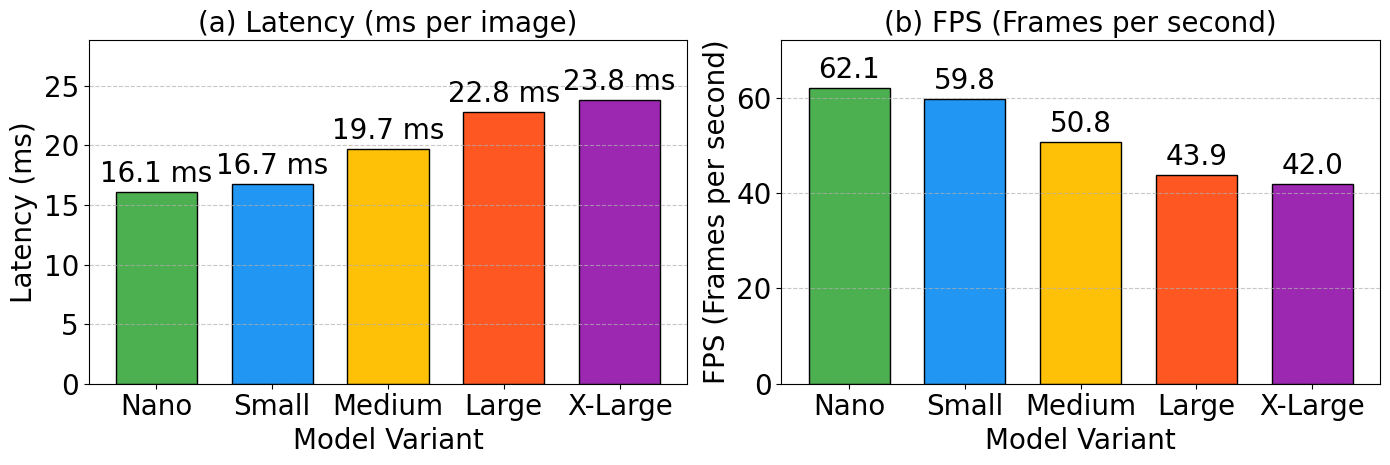

In [ ]:
model_files = {
    'Nano': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/weights/best.pt',
    'Small': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-small-20250808-134916/train16/weights/best.pt',
    'Medium': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/weights/best.pt',
    'Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-large-20250808-111612/train13/weights/best.pt',
    'X-Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-xlarge-20250808-102744/train12/weights/best.pt'
}

test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images'
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

latencies = []
fps_values = []

for model_name, model_path in model_files.items():
    print(f"🔍 Evaluating {model_name}...")
    model = YOLO(model_path)

    start = time.time()
    for img_path in test_images:
        model(img_path, verbose=False)
    end = time.time()

    total_time = end - start
    num_images = len(test_images)
    fps = num_images / total_time
    ms_per_image = (total_time / num_images) * 1000

    print(f"{model_name} - 🕒 FPS: {fps:.2f}, Latency: {ms_per_image:.2f} ms")

    latencies.append(ms_per_image)
    fps_values.append(fps)

colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(model_files))
width = 0.7

# Bar chart latency
bars_latency = ax1.bar(x, latencies, width, color=colors, edgecolor='black')
ax1.set_title('(a) Latency (ms per image)', fontsize=20)
ax1.set_xlabel('Model Variant', fontsize=20)
ax1.set_ylabel('Latency (ms)', fontsize=20)
ax1.set_xticks(x)
ax1.set_xticklabels(model_files.keys(), fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_ylim(0, max(latencies) + 5)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add number
for bar in bars_latency:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f} ms',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=20)

# Bar chart FPS
bars_fps = ax2.bar(x, fps_values, width, color=colors, edgecolor='black')
ax2.set_title('(b) FPS (Frames per second)', fontsize=20)
ax2.set_xlabel('Model Variant', fontsize=20)
ax2.set_ylabel('FPS (Frames per second)', fontsize=20)
ax2.set_xticks(x)
ax2.set_xticklabels(model_files.keys(), fontsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_ylim(0, max(fps_values) + 10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add number
for bar in bars_fps:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=20)

# fig.suptitle('YOLOv8 Variants - Latency & FPS Comparison', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Mean Pixel Error (MPE)

🔍 Evaluating Nano...


100%|██████████| 52/52 [00:17<00:00,  3.03it/s]


📏 Mean Pixel Error: 76.31 px
🔍 Evaluating Small...


100%|██████████| 52/52 [00:01<00:00, 39.73it/s]


📏 Mean Pixel Error: 60.00 px
🔍 Evaluating Medium...


100%|██████████| 52/52 [00:01<00:00, 35.41it/s]


📏 Mean Pixel Error: 35.67 px
🔍 Evaluating Large...


100%|██████████| 52/52 [00:01<00:00, 30.44it/s]


📏 Mean Pixel Error: 55.59 px
🔍 Evaluating X-Large...


100%|██████████| 52/52 [00:01<00:00, 29.88it/s]


📏 Mean Pixel Error: 67.35 px


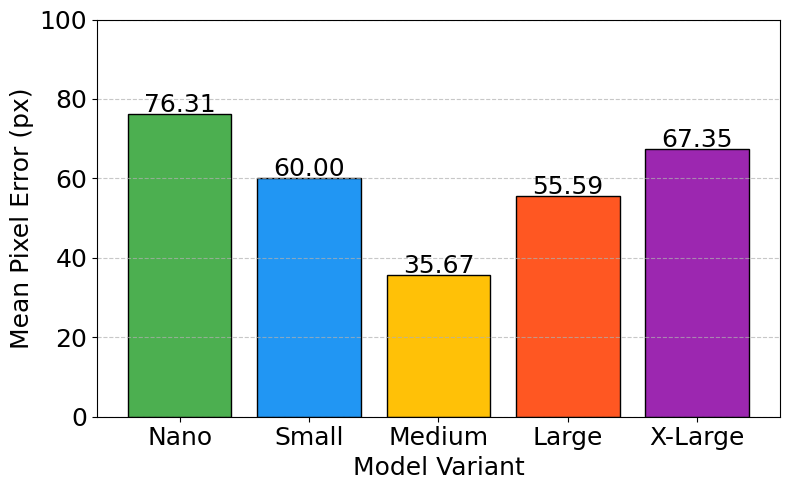

In [ ]:
# Path test images
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images'
test_images = [os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.jpg')]

# Path label YOLO for test set
test_labels_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/labels'

def yolo_keypoints_to_pixel(kpts_norm, img_w, img_h):
    """Konversi keypoints YOLO (x_norm, y_norm, visible) -> pixel"""
    kpts_px = []
    for i in range(0, len(kpts_norm), 3):
        x = kpts_norm[i] * img_w
        y = kpts_norm[i+1] * img_h
        v = kpts_norm[i+2]  # visibility (0/1/2)
        kpts_px.append((x, y, v))
    return kpts_px

# Path model YOLOv8 training result
model_files = {
    'Nano': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/weights/best.pt',
    'Small': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-small-20250808-134916/train16/weights/best.pt',
    'Medium': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/weights/best.pt',
    'Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-large-20250808-111612/train13/weights/best.pt',
    'X-Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-xlarge-20250808-102744/train12/weights/best.pt'
}

# Save MPE results for all models
mpe_results = {}

# Evaluate each model
for model_name, model_path in model_files.items():
    print(f"🔍 Evaluating {model_name}...")
    model = YOLO(model_path)

    pixel_errors = []
    for img_path in tqdm(test_images):
        # Get prediction
        results = model(img_path, verbose=False)
        pred_kpts = results[0].keypoints.xy.cpu().numpy()  # (N, num_kpts, 2) dalam pixel

        # Get GT keypoints
        img_name = os.path.basename(img_path).replace('.jpg', '.txt')
        label_path = os.path.join(test_labels_dir, img_name)

        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            kpts_norm = list(map(float, line[5:]))

        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        gt_kpts = yolo_keypoints_to_pixel(kpts_norm, w, h)

        # Calculate pixel error per keypoint (visible only)
        for i, (gx, gy, gv) in enumerate(gt_kpts):
            if gv > 0:
                px, py = pred_kpts[0][i]
                dist = np.sqrt((px - gx)**2 + (py - gy)**2)
                pixel_errors.append(dist)

    mean_pixel_error = np.mean(pixel_errors)
    mpe_results[model_name] = mean_pixel_error
    print(f"📏 Mean Pixel Error: {mean_pixel_error:.2f} px")

# Custom colors per model (in order Nano → X-Large)
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0']

# Plot the MPE bar chart with appropriate colors
plt.figure(figsize=(8, 5))
plt.bar(mpe_results.keys(), mpe_results.values(), color=colors, edgecolor='black')
plt.xlabel('Model Variant', fontsize=18)
plt.ylabel('Mean Pixel Error (px)', fontsize=18)
# plt.title('Perbandingan MPE Antar Model YOLOv8 Pose')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,100)
plt.tight_layout()

# Display the value above the bar
for i, val in enumerate(mpe_results.values()):
    plt.text(i, val + 0.5, f"{val:.2f}", ha='center', fontsize=18)

plt.show()

## Test on test set (optional)

In [ ]:
yaml_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml"
# === Read YAML file for keypoint sequence ===
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
# Get keypoints names from YAML file
keypoint_names = data_yaml.get('flip_idx', [])
# print(keypoint_names)

# === 1. Load YOLOv8 Pose Model ===
model = YOLO('/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/weights/best.pt')

# === 2. Take 5 Random Images ===
image_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images'
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
random_images = random.sample(all_images, 10)

# === 3. Loop for Inference and Display Results ===
for idx, image_path in enumerate(random_images):
    print(f"\n===== Gambar {idx+1}: {os.path.basename(image_path)} =====")

    results = model(image_path)
    res = results[0]

    # Take the original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes and keypoints whose confidence is > 0.65
    for i, box in enumerate(res.boxes):
        cls_id = int(box.cls[0].item())
        cls_name = model.names[cls_id]

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_rgb, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        print(f"\n  Object {i+1}: {cls_name}")

        if res.keypoints is not None:
            kps = res.keypoints.xy[i]
            conf = res.keypoints.conf[i]

            for j, (xy, c) in enumerate(zip(kps, conf)):
                x, y = int(xy[0].item()), int(xy[1].item())
                if c.item() > 0.8:
                    cv2.circle(img_rgb, (x, y), 6, (0, 0, 255), -1)  # Red circle
                    cv2.putText(img_rgb, str(keypoint_names[j]), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                    print(f"    Keypoint {keypoint_names[j]}: X={x}, Y={y}, Confidence={c.item():.2f}")
                # else:
                #     cv2.circle(img_rgb, (x, y), 6, (0, 255, 0), -1)  # Red circle
                #     cv2.putText(img_rgb, str(j), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                #     print(f"    Keypoint {j}: X={x}, Y={y}, Confidence={c.item():.2f}")
        else:
            print("    Tidak ada keypoints.")

    # Show result image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Pose Detection (Conf > 0.8) - {os.path.basename(image_path)}')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Homography Check (optional)

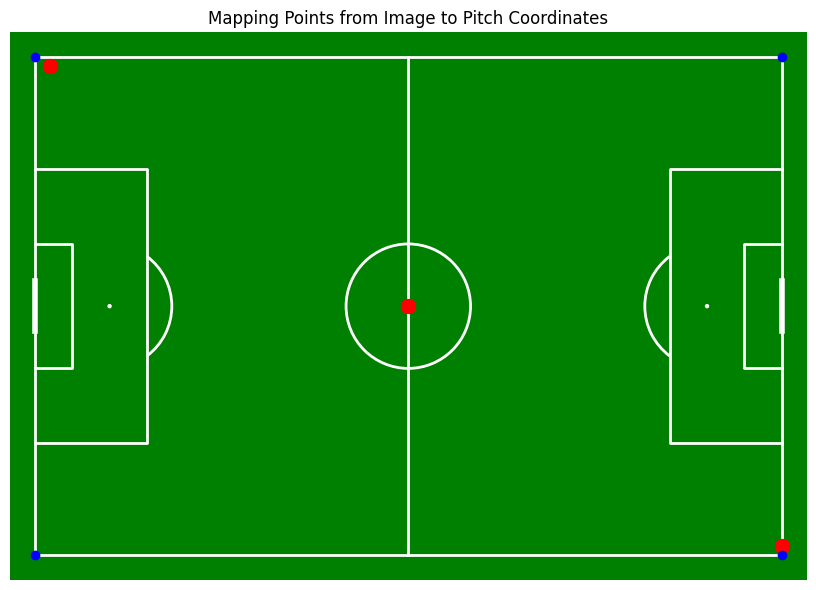

In [ ]:
# === 1. Source points (src_pts from 640x640 image)
src_pts = np.array([
    [70, 50],     # keypoint 0 (top-left)
    [70, 590],    # keypoint 5 (bottom-left)
    [570, 50],    # keypoint 26 (top-right)
    [570, 590],   # keypoint 31 (bottom-right)
], dtype=np.float32)

# === 2. Target points on the pitch (dst_pts)
dst_pts = np.array([
    [0, 0],       # keypoint 0
    [0, 80],      # keypoint 5
    [120, 0],     # keypoint 26
    [120, 80],    # keypoint 31
], dtype=np.float32)

# === 3. Compute the homography matrix
H, _ = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5.0)

# === 4. New points from the image (e.g., detected players)
new_points = np.array([
    [320, 320],  # center of the field
    [80, 60],    # left-side player
    [570, 580],  # right-side player
], dtype=np.float32).reshape(-1, 1, 2)

# === 5. Map image points to pitch coordinates
mapped_points = cv2.perspectiveTransform(new_points, H)

# === 6. Visualization using mplsoccer
pitch = Pitch(pitch_length=120, pitch_width=80, pitch_color='green', line_color='white')
fig, ax = pitch.draw(figsize=(10, 6))

# Plot transformed points
for pt in mapped_points:
    x, y = pt[0]
    ax.plot(x, y, 'ro', markersize=10)  # red: mapped points

# Plot reference points (optional)
for pt in dst_pts:
    x, y = pt
    ax.plot(x, y, 'bo', markersize=6)  # blue: reference points

plt.title("Mapping Points from Image to Pitch Coordinates")
plt.show()


## Homography + Keypoint Detection

In [ ]:
yaml_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml"
# === Read YAML file to get keypoint order ===
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
# Get keypoint names from YAML file
kpt_id = data_yaml.get('flip_idx', [])
# print("kpt_id: ", kpt_id)

# Create keypoint reference
data = {
    'kpt_id': kpt_id,
    'x': [0, 0, 0, 0, 0,
          0, 6, 6, 12, 18,
          18, 18, 18, 60, 60,
          60, 60, 102, 102, 102,
          102, 108, 114, 114, 120,
          120, 120, 120, 120, 120,
          50, 70],
    'y': [0, 18, 30, 50, 62,
          80, 30, 50, 40, 18,
          32, 48, 62, 0, 30,
          50, 80, 18, 32, 48,
          62, 40, 30, 50, 0,
          18, 30, 50, 62, 80,
          40, 40]
}
df_kpt_dst = DataFrame(data)
# display(df_kpt_dst)

# === 1. Load YOLOv8 Pose Model ===

model_paths = {
    'Nano': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/weights/best.pt',
    'Small': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-small-20250808-134916/train16/weights/best.pt',
    'Medium': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/weights/best.pt',
    'Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-large-20250808-111612/train13/weights/best.pt',
    'X-Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-xlarge-20250808-102744/train12/weights/best.pt'
}

# === 2. Select 10 random images ===
image_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images'
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
# random_images = random.sample(all_images, 1)

# === 3. Loop for inference and display results ===

# Initialize list for mapping results
mapping_results = []

for model_variant, model_path in model_paths.items():
    print(f"\n=== Evaluating model: {model_variant} ===")
    model = YOLO(model_path)

    for image_path in all_images:
        # image_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images/worldcup2_450_jpg.rf.2cc08dccb535f1f113aa7708e74b6113.jpg"
        print(f"Processing {os.path.basename(image_path)}")

        results = model(image_path, verbose=False)
        res = results[0]

        # Get original image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes and keypoints with confidence > 0.8
        for i, box in enumerate(res.boxes):
            cls_id = int(box.cls[0].item())
            cls_name = model.names[cls_id]

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(img_rgb, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            # print(f"\n  Object {i+1}: {cls_name}")

            kpt_records = []
            if res.keypoints is not None:
                kps = res.keypoints.xy[i]
                conf = res.keypoints.conf[i]

                for j, (xy, c) in enumerate(zip(kps, conf)):
                    x, y = int(xy[0].item()), int(xy[1].item())
                    if c.item() > 0.8:
                        cv2.circle(img_rgb, (x, y), 6, (255, 0, 0), -1)  # Large red point
                        cv2.putText(img_rgb, str(kpt_id[j]), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                        # print(f"    Keypoint {kpt_id[j]}: X={x}, Y={y}, Confidence={c.item():.2f}")
                        kpt_records.append({
                            'kpt_id': kpt_id[j],
                            'x': x,
                            'y': y,
                            'confidence': round(c.item(), 2)
                        })
            else:
                print(f"No keypoints: {os.path.basename(image_path)}")

        # Keypoints Source DataFrame
        df_kpt_src = DataFrame(kpt_records)
        # display(df_kpt_src)
        if df_kpt_src.empty or len(df_kpt_src) < 4:
            is_mapping = 0
            mapping_results.append({
                'model_variant': model_variant,
                'file_name': os.path.basename(image_path),
                'is_mapping': is_mapping
            })
            continue

        # Join DataFrames
        df_kpt_src_dst = merge(df_kpt_src, df_kpt_dst, on='kpt_id', how='inner', suffixes=('_src', '_dst'))
        # display(df_kpt_src_dst)

        # Get points from DataFrame
        src_pts = df_kpt_src_dst[['x_src', 'y_src']].values.astype(np.float32)
        dst_pts = df_kpt_src_dst[['x_dst', 'y_dst']].values.astype(np.float32)
        # print(src_pts)

        # Compute homography if points are sufficient (min 4)
        H = None
        is_mapping = 0
        H, mask = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5.0) #allow up to 3 pixels of tolerance
        # print("Homography Matrix:\n", H)

        if H is not None:
            is_mapping = 1
        else:
            is_mapping = 0
            print(f"Enough points but homography computation failed: {os.path.basename(image_path)}")
            continue

        # Save mapping result
        mapping_results.append({
            'model_variant': model_variant,
            'file_name': os.path.basename(image_path),
            'is_mapping': is_mapping
        })

        # ################################## UNREMARK TO SEE THE PITCH ##################################
        # # Show the result image
        # plt.imshow(img_rgb)
        # plt.axis('off')
        # # plt.title(f'Pose Detection (Conf > 0.8) - {os.path.basename(image_path)}')
        # plt.show()

        # # === Visualization using mplsoccer
        # # Mask from RANSAC (same length as df_kpt_src_dst)
        # mask_flat = mask.ravel()

        # # Add a new column to mark inliers/outliers
        # df_kpt_src_dst['inlier'] = mask_flat

        # # === Visualization using mplsoccer ===
        # pitch = Pitch(pitch_length=120, pitch_width=80, pitch_color='green', line_color='white')
        # fig, ax = pitch.draw(figsize=(10, 6))

        # for _, row in df_kpt_src_dst.iterrows():
        #     x, y = row['x_dst'], row['y_dst']
        #     if row['inlier'] == 1:
        #         ax.plot(x, y, 'ro', markersize=14)   # inlier → red
        #         ax.text(x, y, str(int(row['kpt_id'])), ha='center', va='center',
        #                 color='yellow', fontsize=11, weight='bold')
        #     else:
        #         ax.plot(x, y, 'yo', markersize=14)   # outlier → yellow
        #         ax.text(x, y, str(int(row['kpt_id'])), ha='center', va='center',
        #                 color='black', fontsize=11, weight='bold')
        # plt.show()

# After the loop, create DataFrame of mapping results
df_mapping_results = DataFrame(mapping_results)
# Add image_source
df_mapping_results["image_source"] = df_mapping_results["file_name"].apply(
    lambda x: "broadcasting" if ("video" in x.lower() or "worldcup" in x.lower()) else "scouting"
)
print("\nSummary Mapping Results:")
display(df_mapping_results)



=== Evaluating model: Nano ===
Processing d82e7a_4_12_png_jpg.rf.0fc3bd536bd35a8f9f713880f18a72e8.jpg
Processing video_3_520_jpg.rf.b20d00a061432d3a78adf28153670a37.jpg
Processing 2e57b9_1_1_png_jpg.rf.ca4fa35bdac9e81d8e5894e352d3a7d7.jpg
Processing video_1_100_jpg.rf.317c6e6bca884962ac89d0dbf991ec9d.jpg
Processing e624c9_7_11_png_jpg.rf.885619398993ab0e08dc995dea2ba45a.jpg
Processing ec783a_7_8_png_jpg.rf.b1ba5f4ca8080200a270dd612c90d47c.jpg
Processing a9f16c_9_11_png_jpg.rf.72fc8222a4b42e96d15657d813348d06.jpg
Processing worldcup2_20_jpg.rf.6f9094ab15037273d2eaf4020d79529a.jpg
Processing 744b27_7_10_png_jpg.rf.2680f04543aaea5f941ad3e848c448ba.jpg
Processing 08fd33_4_9_png_jpg.rf.799ec21c1263380ae023ebd473893298.jpg
Processing video_1_430_jpg.rf.ee943b89e6e02c4c2815f3acb46d198c.jpg
Processing video_3_200_jpg.rf.7f66d4edfa78bf8f6089682c979c6092.jpg
Processing 0a2d9b_2_3_png_jpg.rf.2476ed4abbbc0d737d5ef04453f99776.jpg
Processing 0bfacc_1_4_png_jpg.rf.32432d405e8f4166dcfdf48b5f47664e.jp

,model_variant,file_name,is_mapping,image_source
0,Nano,d82e7a_4_12_png_jpg.rf.0fc3bd536bd35a8f9f71388...,1,scouting
1,Nano,video_3_520_jpg.rf.b20d00a061432d3a78adf281536...,1,broadcasting
2,Nano,2e57b9_1_1_png_jpg.rf.ca4fa35bdac9e81d8e5894e3...,1,scouting
3,Nano,video_1_100_jpg.rf.317c6e6bca884962ac89d0dbf99...,1,broadcasting
4,Nano,e624c9_7_11_png_jpg.rf.885619398993ab0e08dc995...,1,scouting
...,...,...,...,...
254,X-Large,video_3_370_jpg.rf.80b579823e37887c9e8b765a381...,1,broadcasting
255,X-Large,c01561_7_2_png_jpg.rf.d5c61c88c4bf335d6a447024...,1,scouting
256,X-Large,08fd33_0_9_png_jpg.rf.29f4d5cadce2865394d587ca...,1,scouting
257,X-Large,42ba34_9_4_png_jpg.rf.1df45192f2c79ce821802643...,1,scouting


## Homography mapping success rate

Display data with failed homography mapping: 


,model_variant,file_name,is_mapping,image_source
11,Nano,video_3_200_jpg.rf.7f66d4edfa78bf8f6089682c979...,0,broadcasting
17,Nano,worldcup2_450_jpg.rf.2cc08dccb535f1f113aa7708e...,0,broadcasting
44,Nano,worldcup2_430_jpg.rf.39ed3184478796e3383136639...,0,broadcasting
45,Nano,worldcup2_70_jpg.rf.3881db87a1cf64426f94d9c225...,0,broadcasting


,model_variant,file_name,is_mapping,image_source
63,Small,video_3_200_jpg.rf.7f66d4edfa78bf8f6089682c979...,0,broadcasting
69,Small,worldcup2_450_jpg.rf.2cc08dccb535f1f113aa7708e...,0,broadcasting
97,Small,worldcup2_70_jpg.rf.3881db87a1cf64426f94d9c225...,0,broadcasting


,model_variant,file_name,is_mapping,image_source
115,Medium,video_3_200_jpg.rf.7f66d4edfa78bf8f6089682c979...,0,broadcasting
133,Medium,video_1_360_jpg.rf.390967fca7e30bae94d5b154d18...,0,broadcasting


,model_variant,file_name,is_mapping,image_source
167,Large,video_3_200_jpg.rf.7f66d4edfa78bf8f6089682c979...,0,broadcasting
173,Large,worldcup2_450_jpg.rf.2cc08dccb535f1f113aa7708e...,0,broadcasting
185,Large,video_1_360_jpg.rf.390967fca7e30bae94d5b154d18...,0,broadcasting
200,Large,worldcup2_430_jpg.rf.39ed3184478796e3383136639...,0,broadcasting


,model_variant,file_name,is_mapping,image_source
219,X-Large,video_3_200_jpg.rf.7f66d4edfa78bf8f6089682c979...,0,broadcasting
225,X-Large,worldcup2_450_jpg.rf.2cc08dccb535f1f113aa7708e...,0,broadcasting
239,X-Large,worldcup2_320_jpg.rf.db99664dd9ba66b7cd2bad83f...,0,broadcasting
253,X-Large,worldcup2_570_jpg.rf.293bd4488b540ba8023bc3d56...,0,broadcasting


image_source,broadcasting,scouting
model_variant,,
Nano,16,32
Small,17,32
Medium,18,32
Large,16,32
X-Large,16,31


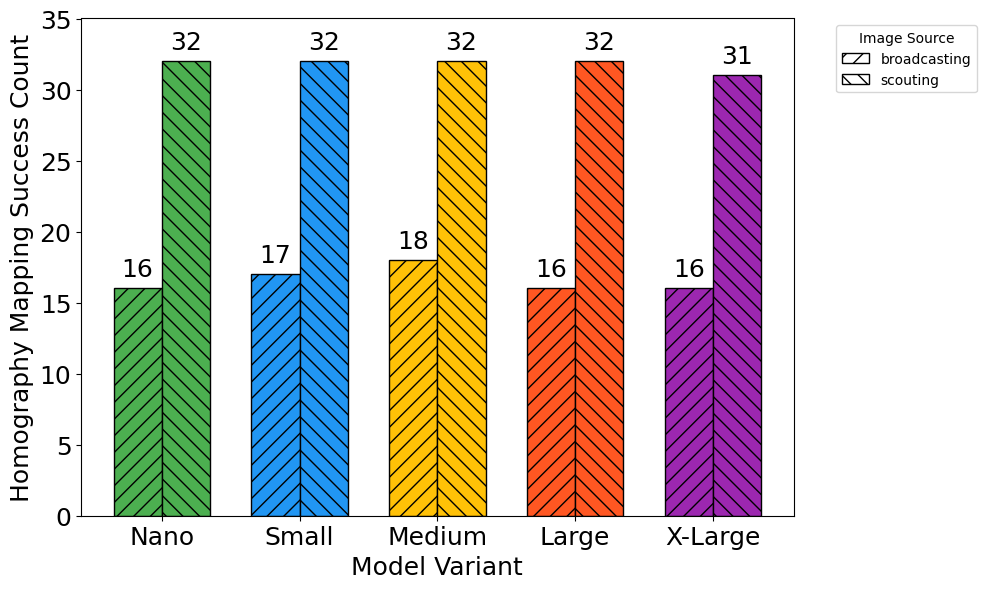

In [ ]:
# Display data with failed homography mapping
print("Display data with failed homography mapping: ")
display(df_mapping_results[(df_mapping_results['model_variant']=='Nano')&(df_mapping_results["is_mapping"] == 0)])
display(df_mapping_results[(df_mapping_results['model_variant']=='Small')&(df_mapping_results["is_mapping"] == 0)])
display(df_mapping_results[(df_mapping_results['model_variant']=='Medium')&(df_mapping_results["is_mapping"] == 0)])
display(df_mapping_results[(df_mapping_results['model_variant']=='Large')&(df_mapping_results["is_mapping"] == 0)])
display(df_mapping_results[(df_mapping_results['model_variant']=='X-Large')&(df_mapping_results["is_mapping"] == 0)])
print("\n")

# Custom colors per model (in order Nano → X-Large)
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722', '#9C27B0']
# Hatches for each image_source
hatches = {
    'broadcasting': '//',
    'scouting': '\\\\'
}
# Specify the desired order
order = ["Nano", "Small", "Medium", "Large", "X-Large"]

# Create a pivot table: index = model_variant, columns = image_source, values ​​= number of successful mappings
pivot_df = df_mapping_results.pivot_table(
    index='model_variant',
    columns='image_source',
    values='is_mapping',
    aggfunc='sum',
    fill_value=0  # if there is a combination that does not exist, fill in 0
)
# Reindex in order
pivot_df = pivot_df.reindex(order)
display(pivot_df)

# Set up bar positions
x = np.arange(len(pivot_df.index))   # model_variant position
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))

# Loop each source → bar cluster
for i, source in enumerate(pivot_df.columns):
    values = pivot_df[source].values
    bars = ax.bar(
        x + i*width, values, width,
        label=source,
        color=[colors[j] for j in range(len(values))],  # color according to model_variant
        edgecolor="black"
    )
    for bar in bars:
        bar.set_hatch(hatches[source])
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    f"{int(height)}", ha='center', va='bottom', fontsize=18)

# Label & formatting
ax.set_xticks(x + width/2)
ax.set_xticklabels(pivot_df.index, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylim(0, 35)
ax.set_xlabel("Model Variant", fontsize=18)
ax.set_ylabel("Homography Mapping Success Count", fontsize=18)

# Legend
handles = [mpatches.Patch(facecolor="white", hatch=hatches[src], edgecolor="black", label=src)
           for src in hatches.keys()]
ax.legend(handles=handles, title="Image Source", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Homography + Keypoint Detection (Best: Medium Model Size)

In [ ]:
yaml_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/data.yaml"
# === Read YAML file to get keypoint order ===
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
# Get keypoint names from YAML file
kpt_id = data_yaml.get('flip_idx', [])
# print("kpt_id: ", kpt_id)

# Create keypoint reference
data = {
    'kpt_id': kpt_id,
    'x': [0, 0, 0, 0, 0,
          0, 6, 6, 12, 18,
          18, 18, 18, 60, 60,
          60, 60, 102, 102, 102,
          102, 108, 114, 114, 120,
          120, 120, 120, 120, 120,
          50, 70],
    'y': [0, 18, 30, 50, 62,
          80, 30, 50, 40, 18,
          32, 48, 62, 0, 30,
          50, 80, 18, 32, 48,
          62, 40, 30, 50, 0,
          18, 30, 50, 62, 80,
          40, 40]
}
df_kpt_dst = DataFrame(data)
# display(df_kpt_dst)

# === 1. Load YOLOv8 Pose Model ===

model_paths = {
    # 'Nano': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-nano-20250808-143733/train17/weights/best.pt',
    # 'Small': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-small-20250808-134916/train16/weights/best.pt',
    'Medium': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-medium-20250808-121511/train14/weights/best.pt',
    # 'Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-large-20250808-111612/train13/weights/best.pt',
    # 'X-Large': '/content/drive/MyDrive/Colab Notebooks/yolo8_pose_results/backup-xlarge-20250808-102744/train12/weights/best.pt'
}

# === 2. Select 10 random images ===
image_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images'
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
# random_images = random.sample(all_images, 1)

# === 3. Loop for inference and display results ===

# Initialize list for mapping results
mapping_results = []

for model_variant, model_path in model_paths.items():
    print(f"\n=== Evaluating model: {model_variant} ===")
    model = YOLO(model_path)

    for image_path in all_images:
        # image_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/soccer-field-localization.v9i.yolov8/test/images/worldcup2_450_jpg.rf.2cc08dccb535f1f113aa7708e74b6113.jpg"
        print(f"Processing {os.path.basename(image_path)}")

        results = model(image_path, verbose=False)
        res = results[0]

        # Get original image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes and keypoints with confidence > 0.8
        for i, box in enumerate(res.boxes):
            cls_id = int(box.cls[0].item())
            cls_name = model.names[cls_id]

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(img_rgb, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            # print(f"\n  Object {i+1}: {cls_name}")

            kpt_records = []
            if res.keypoints is not None:
                kps = res.keypoints.xy[i]
                conf = res.keypoints.conf[i]

                for j, (xy, c) in enumerate(zip(kps, conf)):
                    x, y = int(xy[0].item()), int(xy[1].item())
                    if c.item() > 0.8:
                        cv2.circle(img_rgb, (x, y), 6, (255, 0, 0), -1)  # Large red point
                        cv2.putText(img_rgb, str(kpt_id[j]), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                        # print(f"    Keypoint {kpt_id[j]}: X={x}, Y={y}, Confidence={c.item():.2f}")
                        kpt_records.append({
                            'kpt_id': kpt_id[j],
                            'x': x,
                            'y': y,
                            'confidence': round(c.item(), 2)
                        })
            else:
                print(f"No keypoints: {os.path.basename(image_path)}")

        # Keypoints Source DataFrame
        df_kpt_src = DataFrame(kpt_records)
        # display(df_kpt_src)
        if df_kpt_src.empty or len(df_kpt_src) < 4:
            print("Detected keypoints are less than 4 points.")
            is_mapping = 0
            mapping_results.append({
                'model_variant': model_variant,
                'file_name': os.path.basename(image_path),
                'is_mapping': is_mapping
            })
            # Show the result image
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.show()
            continue

        # Join DataFrames
        df_kpt_src_dst = merge(df_kpt_src, df_kpt_dst, on='kpt_id', how='inner', suffixes=('_src', '_dst'))
        # display(df_kpt_src_dst)

        # Get points from DataFrame
        src_pts = df_kpt_src_dst[['x_src', 'y_src']].values.astype(np.float32)
        dst_pts = df_kpt_src_dst[['x_dst', 'y_dst']].values.astype(np.float32)
        # print(src_pts)

        # Compute homography if points are sufficient (min 4)
        H = None
        is_mapping = 0
        H, mask = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=10.0) #allow up to 3 pixels of tolerance
        # print("Homography Matrix:\n", H)

        if H is not None:
            is_mapping = 1
        else:
            is_mapping = 0
            print(f"Enough points but homography computation failed: {os.path.basename(image_path)}")
            continue

        # Save mapping result
        mapping_results.append({
            'model_variant': model_variant,
            'file_name': os.path.basename(image_path),
            'is_mapping': is_mapping
        })

        # # === New points from image (e.g. player detections)
        # new_points = np.array([
        #     [320, 320],  # center pitch
        #     [580, 440],  # left player
        #     [310, 418],  # right player
        # ], dtype=np.float32).reshape(-1, 1, 2)
        # # === Map to pitch coordinates
        # mapped_points = cv2.perspectiveTransform(new_points, H)
        # # print(mapped_points)

        ################################## UNREMARK TO SEE THE PITCH ##################################
        # Show the result image
        plt.imshow(img_rgb)
        plt.axis('off')
        # plt.title(f'Pose Detection (Conf > 0.8) - {os.path.basename(image_path)}')
        plt.show()

        # === Visualization using mplsoccer
        # Mask from RANSAC (same length as df_kpt_src_dst)
        mask_flat = mask.ravel()

        # Add a new column to mark inliers/outliers
        df_kpt_src_dst['inlier'] = mask_flat

        # === Visualization using mplsoccer ===
        pitch = Pitch(pitch_length=120, pitch_width=80, pitch_color='green', line_color='white')
        fig, ax = pitch.draw(figsize=(10, 6))

        for _, row in df_kpt_src_dst.iterrows():
            x, y = row['x_dst'], row['y_dst']
            if row['inlier'] == 1:
                ax.plot(x, y, 'ro', markersize=14)   # inlier → red
                ax.text(x, y, str(int(row['kpt_id'])), ha='center', va='center',
                        color='yellow', fontsize=11, weight='bold')
            else:
                ax.plot(x, y, 'yo', markersize=14)   # outlier → yellow
                ax.text(x, y, str(int(row['kpt_id'])), ha='center', va='center',
                        color='black', fontsize=11, weight='bold')
        plt.show()

# After the loop, create DataFrame of mapping results
df_mapping_results = DataFrame(mapping_results)
print("\nSummary Mapping Results:")
display(df_mapping_results)


Output hidden; open in https://colab.research.google.com to view.